# W207 Final Project - Zillow Housing Data
We examined a dataset from Zillow that was posted to Kaggle in 2017. The dataset includes many features from houses available in the Zillow catalogue. The task is to predict what the $logerror$ of the Zillow's estimate of the house's sale price ($Zestimate$) against the actual sale price of the house ($SalePrice$). The $logerror$ is defined as follows:

$$ logerror = log(Zestimate) - log(SalePrice) $$

The competition was evaluated on the submission's Mean Absolute Error($MAE$). This is calculated as follows:

$$ MAE = \frac{\sum_{i=1}^n \left|y_i - \hat{y}_i\right|}{n} $$

Where $n$ is the number of entries in the dataset, $y_i$ is the actual value of the datapoint $i$, and $\hat{y}_i$ is the predicted value of the datapoint $i$.

## Setup
### Import Required Libraries

In [243]:
from time import time
import re as re
from datetime import datetime
import math
import json

import numpy as np
from numpy import errstate,isneginf
from scipy import stats
import pandas as pd
from pandas.plotting import register_matplotlib_converters; register_matplotlib_converters()
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

from scipy import stats
import reverse_geocoder as rg # https://github.com/thampiman/reverse-geocoder
import seaborn as sns
sns.set(style = 'white')

import gauntlet


%matplotlib inline

### Read in Data

In [161]:
train_2016 = pd.read_csv("train_2016_v2.csv")
properties_2016 = pd.read_csv("properties_2016.csv")

C:\Users\amybr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploratory Data Analysis

First we look at the housing features and label dataframes

In [272]:
# look at properties 2016 dataframe
properties_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
storytypeid,1624,NaN,NaN,NaN,7,0,7,7,7,7,7
basementsqft,1628,NaN,NaN,NaN,646.883,538.793,20,272,534,847.25,8516
yardbuildingsqft26,2647,NaN,NaN,NaN,278.297,369.732,10,96,168,320,6141
fireplaceflag,5163,1,True,5163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
architecturalstyletypeid,6061,NaN,NaN,NaN,7.20261,2.43629,2,7,7,7,27
typeconstructiontypeid,6747,NaN,NaN,NaN,5.99956,0.38405,4,6,6,6,13
finishedsquarefeet13,7672,NaN,NaN,NaN,1178.9,357.073,120,960,1296,1440,2688
buildingclasstypeid,12629,NaN,NaN,NaN,3.72595,0.5017,1,3,4,4,5
decktypeid,17096,NaN,NaN,NaN,66,0,66,66,66,66,66
finishedsquarefeet6,22001,NaN,NaN,NaN,2414.34,7695.3,117,1079,1992,3366,952576


In [163]:
# look at train 2016 dataframe
train_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
parcelid,90275,NaN,NaN,NaN,1.29847e+07,2.50451e+06,1.07117e+07,1.15595e+07,1.25473e+07,1.42276e+07,1.62961e+08
logerror,90275,NaN,NaN,NaN,0.0114572,0.161079,-4.605,-0.0253,0.006,0.0392,4.737
transactiondate,90275,352,2016-07-29,910,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We combine these two dataframes, joining on the `parcelid`.

In [273]:
# merge the logerror and transactiondate from properties into train dataframe
df = properties_2016.merge(train_2016, on='parcelid', how='inner',left_index=True,right_index=True, copy='False')
df.set_index(keys='parcelid',inplace=True)

Before we start dropping columns, add a column stating what percentage of values were populated to begin with.

In [274]:
df['feature_cnt'] = (df.isnull().sum(axis=1))*1.0/len(df.columns)

In [275]:
df.columns

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'y

## It's about to get weird

In [45]:
# combine pooltypeid into one categorical variable
austins_df = df.copy()
all_but_pooltype = [c for c in df.columns if not c.startswith('pooltypeid')]
austins_df = austins_df[all_but_pooltype]
austins_df['pooltypeid'] = np.nan
austins_df['pooltypeid'].mask(~df['pooltypeid10'].isna(), other=10, inplace=True)
austins_df['pooltypeid'].mask(~df['pooltypeid2'].isna(), other=2, inplace=True)
austins_df['pooltypeid'].mask(~df['pooltypeid7'].isna(), other=7, inplace=True)    

In [46]:
def _missing_col_name(column_name): 
    return column_name + '_missing'

def _check_columns(in_df, op_dict):
    in_col_set = set(in_df.columns)
    op_dict_set = set(list(op_dict.keys()) + ['logerror'])
    
    if in_col_set == op_dict_set:
        return
    
    err_str = "Your operation dictionary is wrong"

    missing_vals = in_col_set - op_dict_set
    if missing_vals:
        err_str += f'; Missing values: {missing_vals}'

    extra_vals = op_dict_set - in_col_set
    if extra_vals:
        err_str += f'; Extra values: {extra_vals}'

    raise ValueError(err_str)
    
def _continuous_bin(df, column_name, bins=None, include_na=False):
    if not bins:
        raise TypeError(f'Column {column_name} missing required argument bins')
    
    if include_na:
        df[_missing_col_name(column_name)] = df[column_name].isna()

    if isinstance(bins, int):
        bins = pd.qcut(df[column_name], bins, duplicates='drop', labels=False)
        bin_df = pd.get_dummies(bins, prefix=column_name)
    else:
        bin_df = pd.cut(df[column_name], bins, labels=[column_name], include_lowest=True)
        
    df.drop(labels=[column_name], axis='columns', inplace=True)
    return pd.concat([df, bin_df], axis='columns')

    
def _continuous_asis(df, column_name, handle_missing='drop', normalize=False):
    if handle_missing == 'drop':
        df.dropna(axis=0, subset=[column_name], inplace=True)
    elif handle_missing == 'dummy':
        df[_missing_col_name(column_name)] = df[column_name].isna()
        df[column_name].fillna(value=0, inplace=True)
    else:
        raise ValueError(f'handle_missing value {handle_missing} is not supported')
    
    # TODO if we chose dummy, then we are normalizing with a heavy skew at 0... what do?
    if normalize:
        df[column_name] = (df[column_name] - df[column_name].mean()) / (df[column_name].std() + 1e6)
    return df
        
    
def _categorical_bin(df, column_name, bin_vals=None, include_na=False):
    if not bin_vals:
        raise TypeError(f'Missing required argument bin_vals for column {column_name}')
        
    if include_na:
        df[_missing_col_name(column_name)] = df[column_name].isna()
    
    for i, bin_subset in enumerate(bin_vals):
        df[column_name + f'bin{i}'] = df[column_name].isin(bin_subset)
        
    return df
        
    
def _categorical_asis(df, column_name, include_na=False):
    
    df = pd.get_dummies(df, dummy_na=include_na, columns=[column_name])
    
    return df

def _categorical_true_false(df, column_name):
    df[column_name] = ~df[column_name].isna()
    return df

_op_fn_dict = {
    'categorical': {
        'bin': _categorical_bin,
        'asis': _categorical_asis,
        'tf': _categorical_true_false,
    },
    'continuous': {
        'bin': _continuous_bin,
        'asis': _continuous_asis,
    }
}
    
    
def i_hate_this_data(in_df, op_dict):
    _check_columns(in_df, op_dict)
    
    out_df = in_df.copy()
    for column_name, value in op_dict.items():
        t = value['type']
        
        if t == 'drop':
            out_df.drop(labels=[column_name], axis='columns', inplace=True)
            continue
        
        method = value['method']
        kwargs = value['kwargs']
        
        out_df = _op_fn_dict[t][method](out_df, column_name, **kwargs)
        
    return out_df
    

In [47]:
with open('./sample_op_dict.json', 'r')  as fp:
    sample_op_dict = json.load(fp)
    
sample_df = i_hate_this_data(austins_df, sample_op_dict)

### Clean
First we do some minimal conversion of the data

In [276]:
# convert the transactiondate column to a datetime
df.transactiondate = pd.to_datetime(df.transactiondate, infer_datetime_format=True)

# convert Lat/Long to actual Lat/Long
# note - run this cell one-time or latitude/longtitude will keep dividing by 1e6
df['latitude'] = df['latitude']/1e6
df['longitude'] = df['longitude']/1e6

# combine latitude and longtitude into one column
df['latlng'] = df['latitude'].map(str) + ',' + df['longitude'].map(str)

#### Lat-Long Conversion
Now we want to map the latitude and longitudes provided to cities and counties

In [277]:
# lookup lat/long locations
coordinates = df["latlng"].apply(lambda x: tuple(x.split(',')))
results = rg.search(coordinates.tolist())

city = [result.get("name") for result in results]
county = [result.get("admin2") for result in results]

df['city'] = city
df['county'] = county

# create a combined variable for better categorization
df['county_city'] = list(zip(county, city))
df['county_city'] = df['county_city'].astype('category')

The zillow kaggle page suggests that it only provides data from the Los Angeles, Orange, and Ventura counties in California. We can see that there are some values outside of these counties. We elect to filter these out.

In [278]:
df = df[df['county'].isin(['Los Angeles County', 'Orange County', 'Ventura County'])]
print(df['county'].value_counts())

Los Angeles County    59641
Orange County         22972
Ventura County         7535
Name: county, dtype: int64


We noticed both categorical and continuous columns in the dataset, which we need to analyze differently to explore their effect on the logerror

In [279]:
# identify categorical versus continuous columns 
categorical_columns = ['airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid',
                       'buildingqualitytypeid', 'heatingorsystemtypeid', 'latitude', 'longitude',
                       'propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty',
                       'regionidneighborhood','regionidzip','typeconstructiontypeid','censustractandblock',
                       'bathroomcnt','bedroomcnt','assessmentyear', 'roomcnt', 'hashottuborspa',
                       'taxdelinquencyflag','fireplaceflag', 'city', 'county', 'county_city','propertyzoningdesc']

continuous_columns = list(set(df.columns) - set(categorical_columns))
continuous_columns.remove('logerror')
print(len(continuous_columns))


37


TODO - Speak to the plots below. Or maybe include all of these plots in the appendix and just reference interesting ones

In [ ]:
# feature count minus one due to 
plots_per_block = 8

def plot_scatter(columns, col_count=2):
    feature_count = len(columns)
    row_count = math.ceil(float(feature_count) / col_count)

    # print(col_count ,row_count, df.columns)
    fig, axes = plt.subplots(row_count, col_count, figsize = (20,24), dpi = 200)

    n_iter = 16
    axes = np.ravel(axes)
    for i, col_name in enumerate(columns):
        ax = axes[i]
        # beautiful plots referenced: https://imaddabbura.github.io/post/kmeans_clustering/
        sns.scatterplot(x=col_name, y='logerror', data=df, hue = 'county', ax = ax)
        ax.set_xlabel(col_name, fontsize = 10)
        ax.set_ylabel('logerror', fontsize = 10)
        ax.set_title('{0} vs logerror'.format(col_name), fontsize = 14)
        ax.tick_params(axis='x', labelsize=8)
        legend = ax.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.1, fontsize=10)
        ax.grid()

    plt.tight_layout()

starting_idx = 0
stopping_idx = starting_idx + plots_per_block

def inc_idx():
    global starting_idx
    global stopping_idx
    starting_idx = stopping_idx
    stopping_idx += plots_per_block
    
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()


KeyboardInterrupt: 

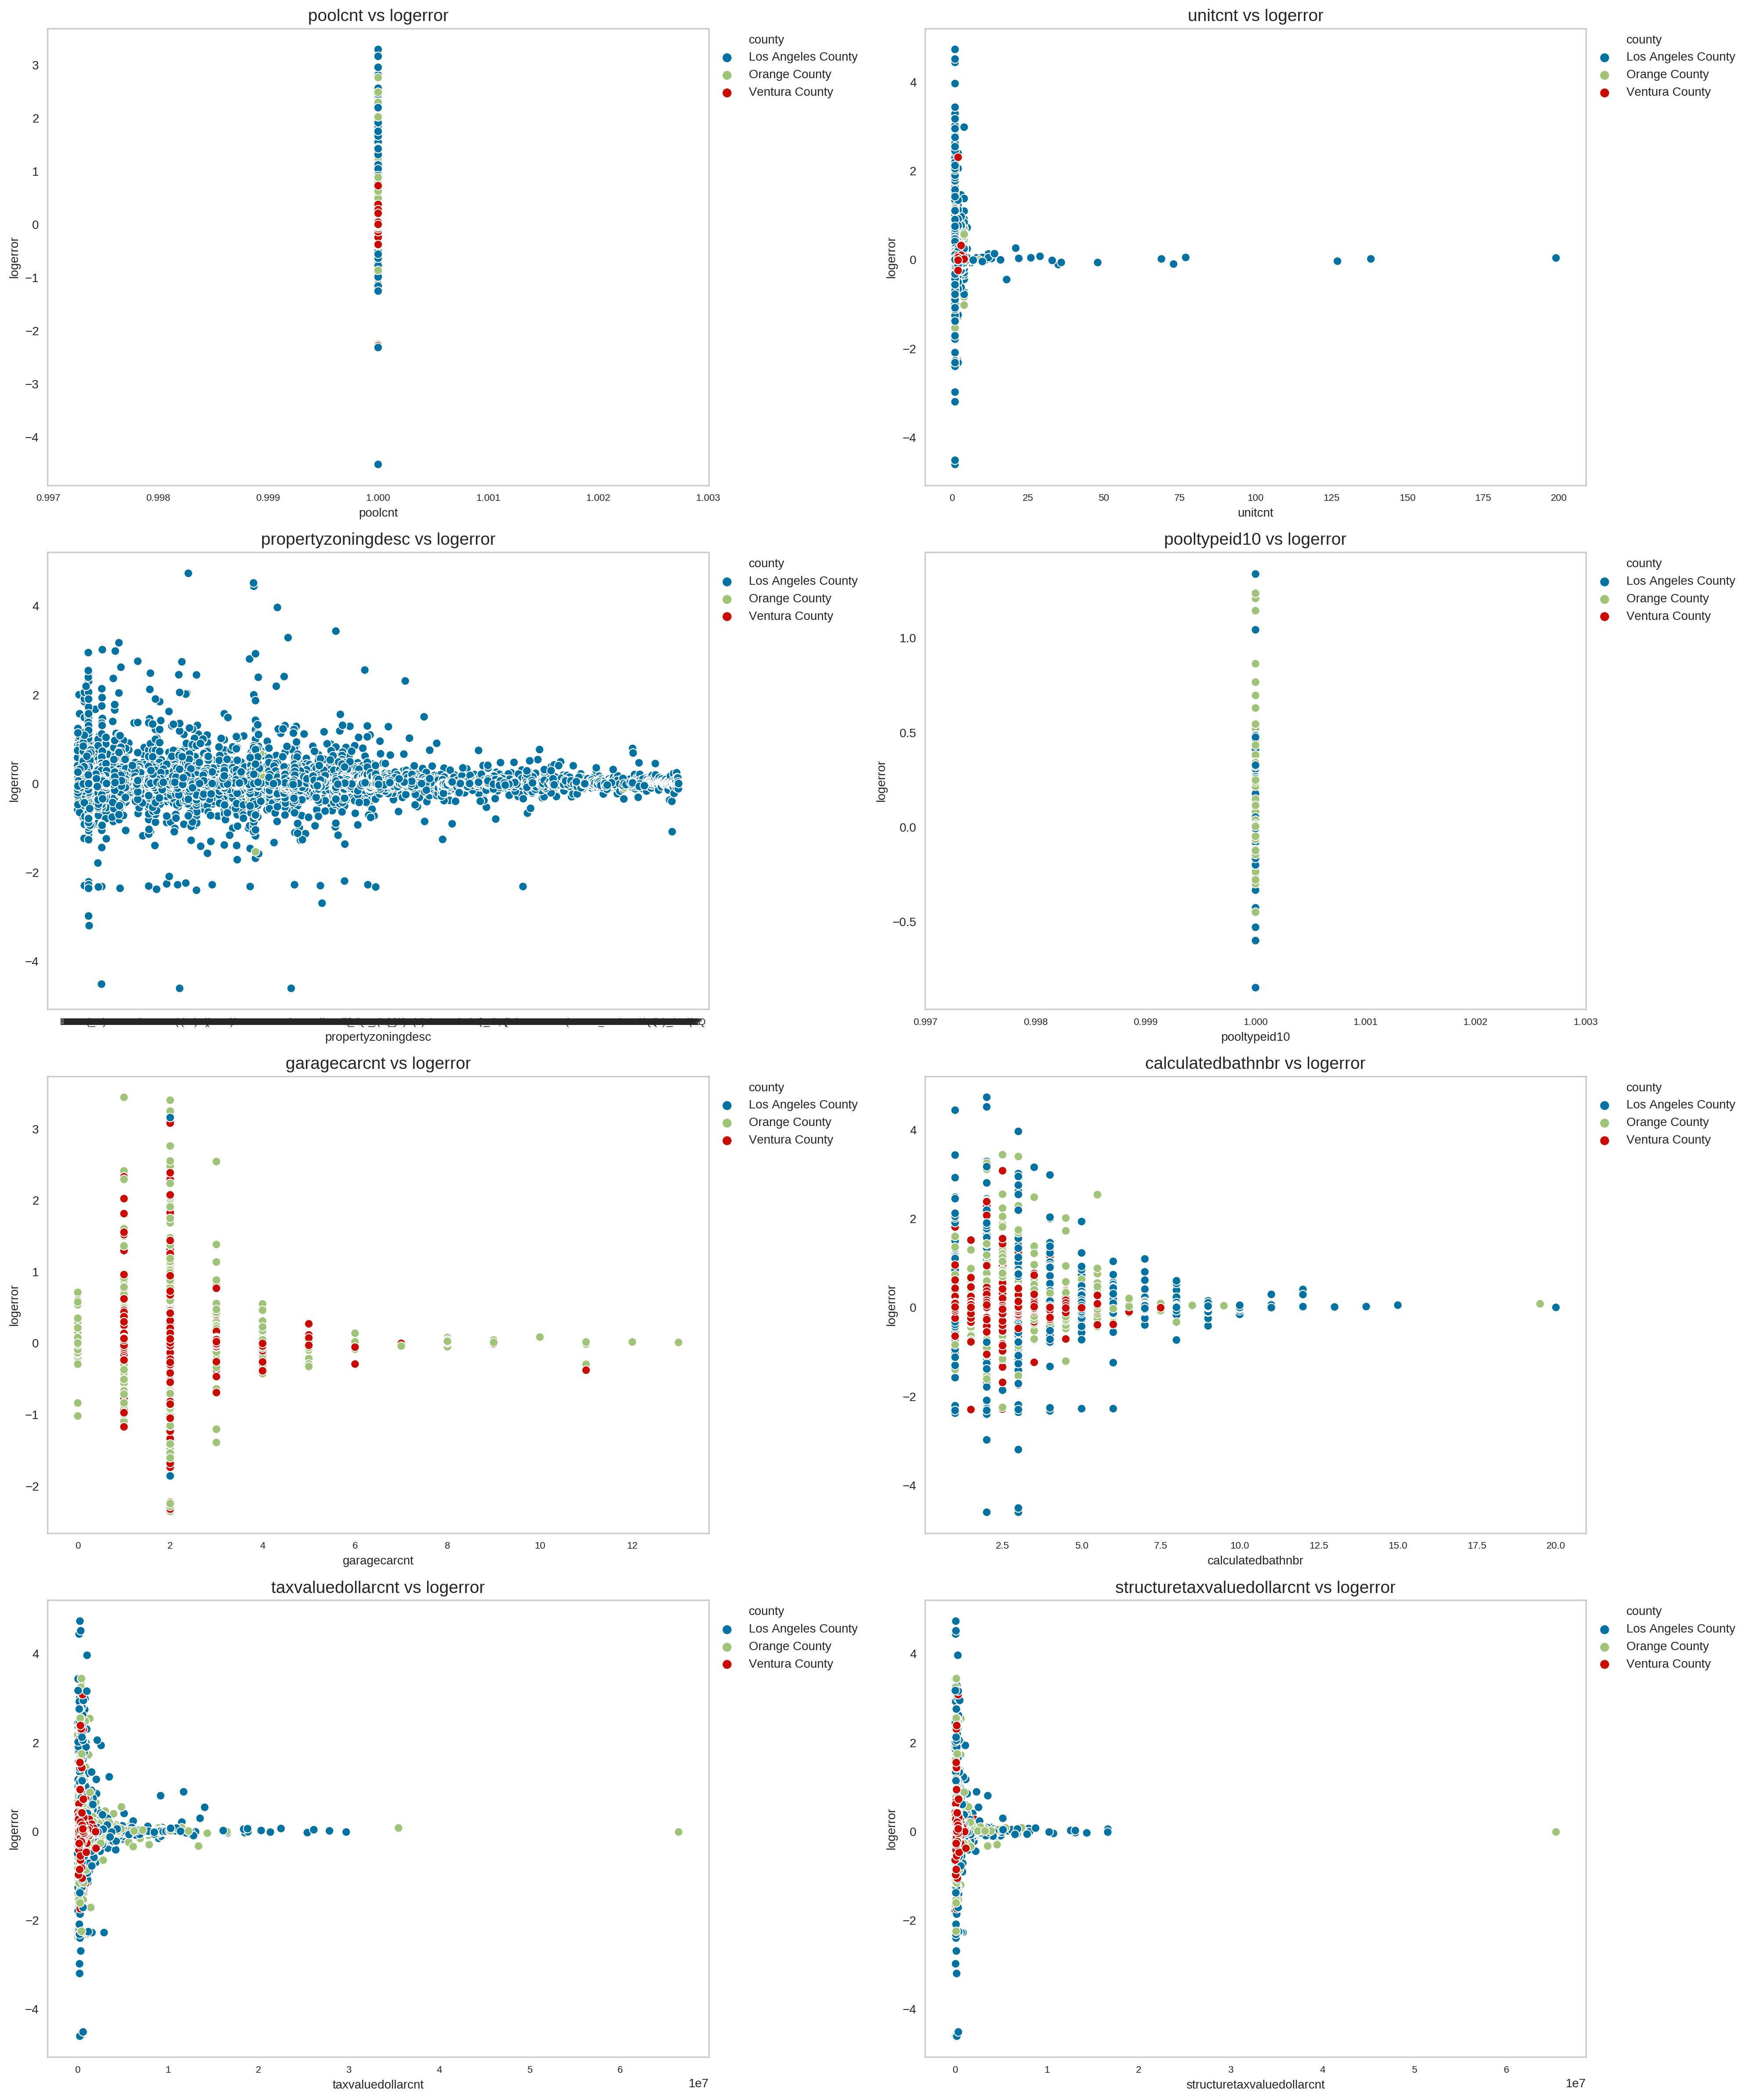

In [12]:
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()

In [ ]:
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()

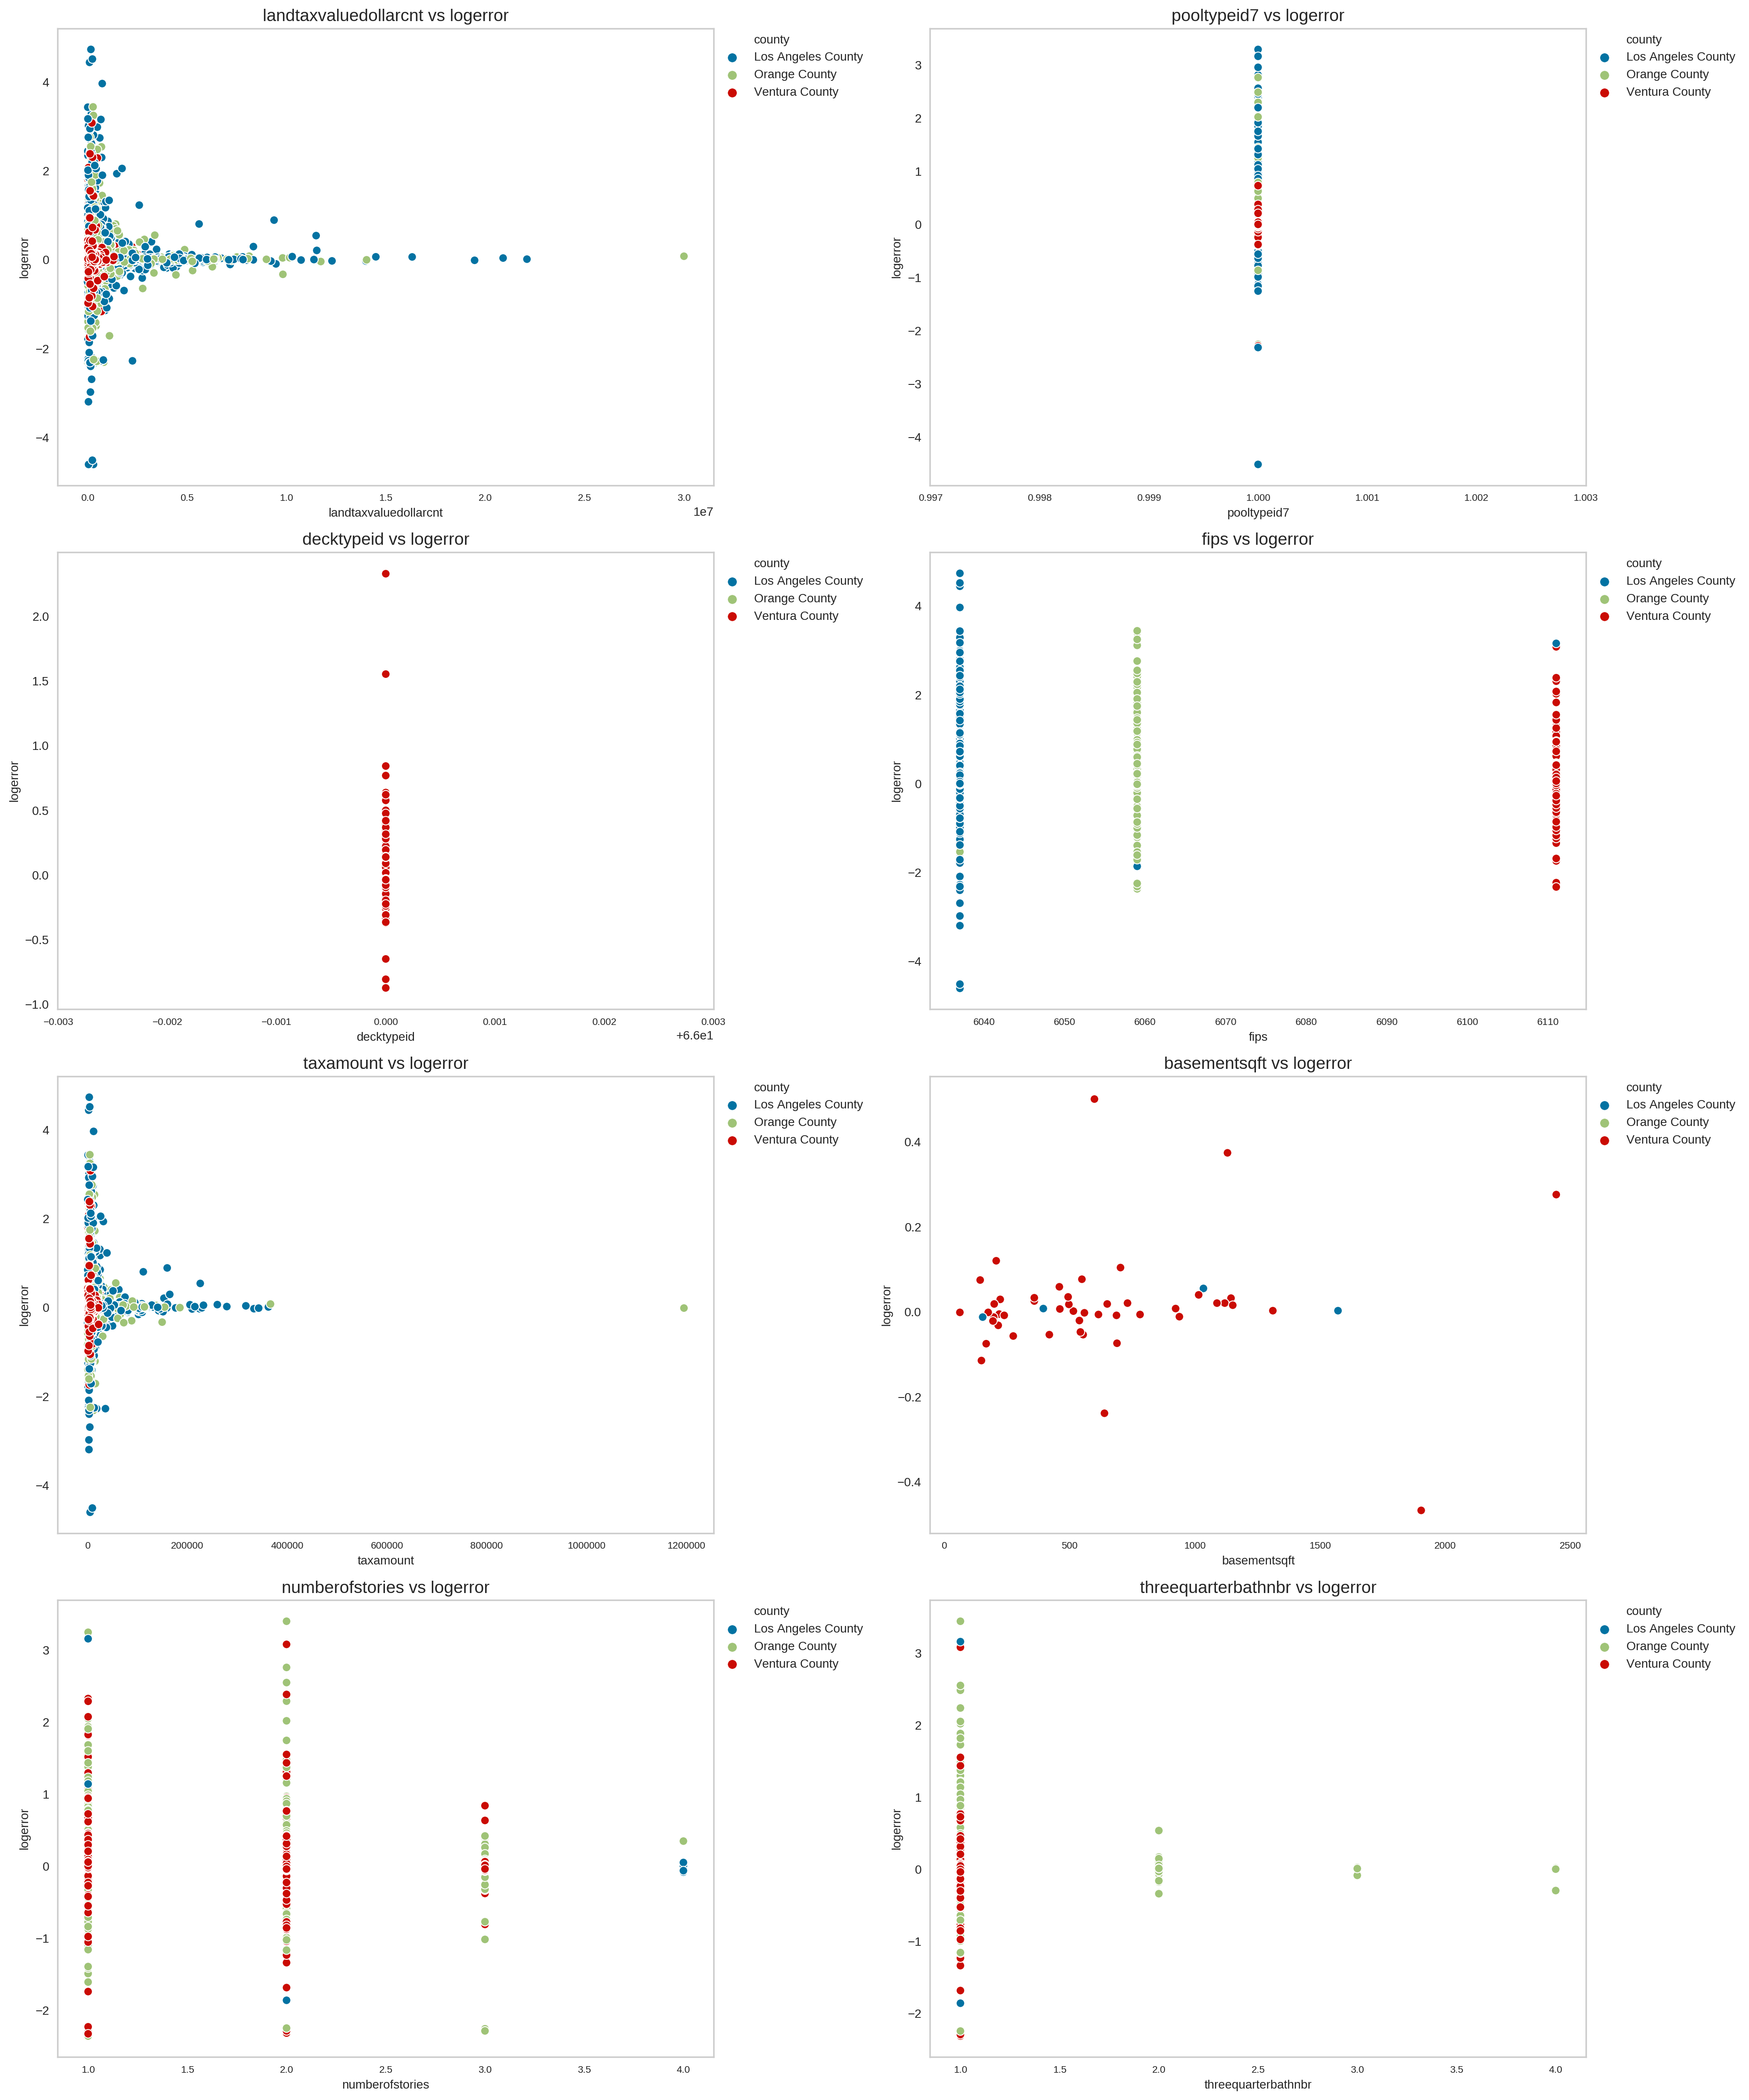

In [14]:
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()

In [ ]:
plot_scatter(continuous_columns[starting_idx:stopping_idx])
inc_idx()
print(len(continuous_columns), stopping_idx)

In [ ]:
plt.figure(figsize=(12,10))
df.corr()['logerror'].sort_values(ascending = False)[1:].plot(kind='bar')

plt.show()

#### Drop duplicative data

We've decided to drop the following obviously duplicative columns whose information is better characterized by other variables present in the dataset. 
* fips - a five-digit code which identifies counties and county equivalents in the United States. Can be represented by city and county data pulled in
* storytypeid -  type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.) Can be represented by basementsqft
* calculatedbathnbr - number of bathrooms in home including fractional bathroom. Can be represented by bathroomcnt

In [280]:
# drop fips, storytypeid, and calcuatedbathnbr
df.drop(labels=['storytypeid','fips', 'calculatedbathnbr'], axis=1,inplace=True)

#### Convert to character format
Now we need to standardize some categorical data from characters to numeric values.

In [281]:
# standardize and convert data to 1 or 0
def convert_yn(x):
    if x in ['True','Y']:
        return 1
    return 0

for col in ['hashottuborspa','taxdelinquencyflag','fireplaceflag']:
    df[col] = df[col].astype('str').map(convert_yn)

#### Analyze continuous variables

There are likely other variables that will not be helpful in improving model performance. We will first explore the continuous variables to understand their effect on logerror, before making a determination to keep or drop columns 

In [282]:
# filter only for columns with numeric values

# some of these are actually categorical. Leave for Ray to analyze
# EH - ideally we replace labels = [long list] with categorical_columns above for code simplicity...

numeric_df = df.select_dtypes(include=['float64','int64']).drop(labels=['airconditioningtypeid','architecturalstyletypeid',
                        'buildingclasstypeid','buildingqualitytypeid','heatingorsystemtypeid','latitude','longitude',
                        'propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty',
                        'regionidneighborhood','regionidzip','typeconstructiontypeid','censustractandblock',
                        'assessmentyear', 'hashottuborspa','taxdelinquencyflag',
                        'fireplaceflag'], axis=1)


In [283]:
def analyze_cols(df):
    """ Takes a data frame and for each column calculates the mean and standard 
        deviation of absolute logerror for listings with this home populated 
        as well as without this home populated.
        
        Performs a two-tailed independent t-test to determine if the listings with 
        this column populated have a different logerror than those without it populated.
        
        Returns a dataframe with all values for each column
    """
    out_list = []
    for col in df.columns:
        if col == "logerror":
            continue
            
        my_dict = {}
        
        # Split the df based on whether the col is populated and just keep absolute value of logerror
        pop_df = np.abs(df[(df[col].notna())]['logerror'])
        nan_df = np.abs(df[(df[col].isnull())]['logerror'])

        # Print out the mean and st dev logerror
        my_dict["col"] = col
        my_dict["n"] = pop_df.shape[0]
        my_dict["mean_pop"] = pop_df.mean()
        my_dict["std_pop"] = pop_df.std()
        my_dict["mean_nan"] = nan_df.mean()
        my_dict["std_nan"] = nan_df.std()
        my_dict['p_val'] = stats.ttest_ind(pop_df,nan_df).pvalue
        
        out_list.append(my_dict)
        
    return pd.DataFrame(out_list)[['col','n','mean_pop','mean_nan','std_pop','std_nan','p_val']].sort_values(by="n").set_index('col')

In [284]:
analyze_cols(numeric_df)

C:\Users\amybr\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\amybr\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\amybr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\amybr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\amybr\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,n,mean_pop,mean_nan,std_pop,std_nan,p_val
col,,,,,,
basementsqft,51,0.065247,0.068440,0.110930,0.146256,0.876114
yardbuildingsqft26,82,0.059695,0.068447,0.171019,0.146214,0.588057
finishedsquarefeet13,249,0.068342,0.068439,0.100739,0.146345,0.991657
decktypeid,572,0.077908,0.068378,0.158115,0.146158,0.120260
finishedsquarefeet6,658,0.058308,0.068513,0.099169,0.146526,0.074509
poolsizesum,905,0.070720,0.068415,0.161899,0.146071,0.637176
pooltypeid2,969,0.068871,0.068434,0.130858,0.146397,0.926259
pooltypeid10,1053,0.066811,0.068458,0.119985,0.146521,0.716339
taxdelinquencyyear,1740,0.072253,0.068363,0.142779,0.146305,0.271946


#### Drop columns

Based on above statistical analysis, we decided to drop columns based on the following thresholds: 
* columns that are less than 5% populated (n < 4,507) 
* columns that have a p-value > 0.5

The columns that meet both of these criteria are the following:
* basementsqft
* yardbuildingsqft26
* finishedsquarefeet13
* poolsizesum
* pooltypeid2
* pooltypeid10

In [285]:
# drop columns that do not meet thresholds for influencing logerror
df.drop(labels=['basementsqft', 'yardbuildingsqft26', 'finishedsquarefeet13', 
                'poolsizesum', 'pooltypeid2', 'pooltypeid10'], axis=1,inplace=True)

# Ray
## Going to convert categorical columns now 

## Not converting the one's we've decided to drop: pooltypeid2, pooltypeid10

## Categorical Columns:

In [286]:
# # Should we consider just converting this to yes or no ? 1/0.  
# 1	Central Yes
# 2	Chilled Water Yes
# 3	Evaporative Cooler Yes
# 4	Geo Thermal? Yes
# 5	None No
# 6	Other No
# 7	Packaged AC Unit Yes
# 8	Partial No
# 9	Refrigeration Yes
# 10	Ventilation Yes
# 11	Wall Unit Yes
# 12	Window Unit Yes
# 13	Yes Yes
def cat_air(x):
    try:
        if x in [1,2,3,4,7,9,10,11,12,13]:
            return 'Yes'
        elif x in [5,6,8]:
            return 'No'
        else:
            return 'Blank'
    except ValueError:
        return 'Blank'
df['airconditioningtypeid'] = df['airconditioningtypeid'].apply(cat_air)

In [287]:
display(df['airconditioningtypeid'].value_counts())

Blank    65846
Yes      24044
No         258
Name: airconditioningtypeid, dtype: int64

In [288]:
print(df.groupby(['county','airconditioningtypeid']).count()['county_city'])

county              airconditioningtypeid
Los Angeles County  Blank                    38289
                    Yes                      21352
Orange County       Blank                    20065
                    No                         258
                    Yes                       2649
Ventura County      Blank                     7492
                    Yes                         43
Name: county_city, dtype: int64


In [289]:
# HeatingOrSystemTypeID	HeatingOrSystemDesc
# 1	Baseboard 
# 2	Central 
# 3	Coal
# 4	Convection
# 5	Electric
# 6	Forced air
# 7	Floor/Wall
# 8	Gas
# 9	Geo Thermal
# 10	Gravity
# 11	Heat Pump
# 12	Hot Water
# 13	None
# 14	Other
# 15	Oil
# 16	Partial
# 17	Propane
# 18	Radiant
# 19	Steam
# 20	Solar
# 21	Space/Suspended
# 22	Vent
# 23	Wood Burning
# 24	Yes
# 25	Zone
def cat_heat(x):
    try:
        if x in [1,2,3,4,5,6,7,8,9,11,12,15,16,17,18,19,20,21,22,23,24,25]:
            return 'Yes'
        elif x in [10,13,14]:
            return 'No'
        else:
            return 'Blank'
    except ValueError:
        return 'Blank'
df['heatingorsystemtypeid'] = df['heatingorsystemtypeid'].apply(cat_heat)
print(df.groupby(['county','heatingorsystemtypeid']).count()['county_city'])

county              heatingorsystemtypeid
Los Angeles County  Blank                     7929
                    Yes                      51712
Orange County       Blank                    20721
                    No                          44
                    Yes                       2207
Ventura County      Blank                     7486
                    Yes                         49
Name: county_city, dtype: int64


In [290]:
# PropertyLandUseTypeID	PropertyLandUseDesc
# 31	Commercial/Office/Residential Mixed Used
# 46	Multi-Story Store
# 47	Store/Office (Mixed Use)
# 246	Duplex (2 Units, Any Combination)
# 247	Triplex (3 Units, Any Combination)
# 248	Quadruplex (4 Units, Any Combination)
# 260	Residential General
# 261	Single Family Residential
# 262	Rural Residence
# 263	Mobile Home
# 264	Townhouse
# 265	Cluster Home
# 266	Condominium
# 267	Cooperative
# 268	Row House
# 269	Planned Unit Development
# 270	Residential Common Area
# 271	Timeshare
# 273	Bungalow
# 274	Zero Lot Line
# 275	Manufactured, Modular, Prefabricated Homes
# 276	Patio Home
# 279	Inferred Single Family Residential
# 290	Vacant Land - General
# 291	Residential Vacant Land
# def propertylandusetypeid(x):
#     try:
#         if x in [1,2,3,4,5,7,8,9,11,12,15,16,17,18,19,20,23,24]:
#             return 'Yes'
#         elif x in [6,10,13,14,21,22,25]:
#             return 'No'
#         else:
#             return 'Blank'
#     except ValueError:
#         return 'Blank'
# combined_df['propertylandusetypeid'] = combined_df['propertylandusetypeid'].apply(cat_heat)
print(df.groupby(['county','propertylandusetypeid']).count()['county_city'])

county              propertylandusetypeid
Los Angeles County  31.0                       311
                    47.0                       146
                    246.0                     3082
                    247.0                     1084
                    248.0                      957
                    260.0                       93
                    261.0                    42433
                    263.0                      914
                    264.0                        9
                    265.0                        7
                    266.0                     8804
                    267.0                       55
                    269.0                     1746
Orange County       47.0                        15
                    246.0                      189
                    247.0                       91
                    248.0                      170
                    260.0                        1
                    261.0               

In [291]:
#Covert this to high quality, medium, low?  (Range is from 1-12)

def cat_qual(x):
    try:
        if x <=4:
            return 'High'
        elif x <=8:
            return 'Medium'
        else:
            return 'Low'
    except ValueError:
        return 'Blank'
df['buildingqualitytypeid'] = df['buildingqualitytypeid'].apply(cat_qual)

print(df.groupby(['county','buildingqualitytypeid']).count()['county_city'])


county              buildingqualitytypeid
Los Angeles County  High                     22402
                    Low                       3808
                    Medium                   33431
Orange County       High                       298
                    Low                      22222
                    Medium                     452
Ventura County      High                        47
                    Low                       7488
Name: county_city, dtype: int64


In [292]:
#We want to remove architecturalstyletypeid (170 records) and typeconstructiontypeid (201 records) and buildingclasstypeid (440 records)

print(df.groupby(['county','architecturalstyletypeid']).count()['county_city'])

print(df.groupby(['county','typeconstructiontypeid']).count()['county_city'])

print(df.groupby(['county','buildingclasstypeid']).count()['county_city'])

county              architecturalstyletypeid
Los Angeles County  7.0                           1
Orange County       2.0                           4
                    3.0                           1
                    7.0                         158
                    8.0                          13
                    21.0                          6
Name: county_city, dtype: int64
county              typeconstructiontypeid
Los Angeles County  6.0                         2
Orange County       4.0                         2
                    6.0                       197
Name: county_city, dtype: int64
county              buildingclasstypeid
Los Angeles County  2.0                      3
                    3.0                     94
                    4.0                    340
                    5.0                      3
Name: county_city, dtype: int64


### Columns to drop: architecturalstyletypeid (170 records) and typeconstructiontypeid (201 records) and buildingclasstypeid (440 records). Drop latitude, longitude we have used it to map already. (Unless we want to try to use that somehow later)

In [293]:
print(df.groupby(['county','roomcnt']).count()['county_city'])


county              roomcnt
Los Angeles County  0.0        59469
                    3.0            4
                    4.0            8
                    5.0           29
                    6.0           43
                    7.0           42
                    8.0           25
                    9.0            9
                    10.0           5
                    11.0           2
                    12.0           2
                    13.0           1
                    22.0           1
Orange County       0.0         9203
                    1.0            4
                    2.0            2
                    3.0          130
                    4.0          662
                    5.0         1946
                    6.0         3963
                    7.0         3329
                    8.0         2639
                    9.0          876
                    10.0         163
                    11.0          30
                    12.0          16
          

### We will also drop census tract information. Doesn't tell us anything interesting. 
### Definition: A Census Block Group is a geographical unit used by the United States Census Bureau which is between the Census Tract and the Census Block. It is the smallest geographical unit for which the bureau publishes sample data, i.e. data which is only collected from a fraction of all households.

### Fireplace flag only has 149 actual homes that have a fire place flag. Will that matter much? Keep for now. Idk what homes in CA even have fire places... lol

### I'm going to remove the record with 86 rooms in OC. It's way too ridiculous. See above. Keep roomcnt as a variable, but make it exponential? not sure. Once standardized it might not matter.

In [294]:
print(len(df))
df = df[df['roomcnt'] != 86.0]
print(len(df))

90148
90147


In [295]:
print(df.groupby(['county','bathroomcnt']).count()['county_city'])

county              bathroomcnt
Los Angeles County  0.0             1926
                    1.0            12410
                    1.5               10
                    2.0            25470
                    2.5               39
                    3.0            14485
                    3.5                6
                    4.0             3377
                    4.5                9
                    5.0             1078
                    5.5                1
                    6.0              468
                    6.5                2
                    7.0              176
                    8.0              117
                    9.0               33
                    10.0              16
                    11.0               5
                    12.0               9
                    13.0               1
                    14.0               1
                    15.0               1
                    20.0               1
Orange County       0.0  

In [296]:
print(df.groupby(['county','bedroomcnt']).count()['county_city'])

county              bedroomcnt
Los Angeles County  0.0            2079
                    1.0            1768
                    2.0           13440
                    3.0           23754
                    4.0           12991
                    5.0            3476
                    6.0            1208
                    7.0             301
                    8.0             384
                    9.0             133
                    10.0             52
                    11.0             16
                    12.0             34
                    13.0              1
                    14.0              2
                    16.0              2
Orange County       0.0            1296
                    1.0             686
                    2.0            3927
                    3.0            8679
                    4.0            6635
                    5.0            1497
                    6.0             208
                    7.0              32
         

## Going to treat roomcnt, bedroomcnt, bathroomcnt as continuous and not remove them in categorical separation. PCA will probably handle that linear relationship b/w those rooms.

In [297]:
print(df.groupby(['county','assessmentyear']).count()['county_city'])

county              assessmentyear
Los Angeles County  2003.0                1
                    2014.0               33
                    2015.0            59607
Orange County       2014.0                4
                    2015.0            22967
Ventura County      2014.0                1
                    2015.0             7534
Name: county_city, dtype: int64


## Removing assessment year, no useful information and dominantly 2015.

In [298]:
df['regionidcounty'].head(5)

parcelid
10754147    3101.0
10759547    3101.0
10843547    3101.0
10859147    3101.0
10879947    3101.0
Name: regionidcounty, dtype: float64

In [ ]:
## Below print just tells us total columns I should be analyzing to make sure I don't miss anything.
##Can remove if everyone is okay w/ my work

In [299]:
total_col = df.columns
numeric_col = numeric_df.columns
missing_col = []
for x in total_col:
    if(x in numeric_df.columns):
        None
    else:
        missing_col.append(x)
        
print(missing_col)

['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'hashottuborspa', 'heatingorsystemtypeid', 'latitude', 'longitude', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'typeconstructiontypeid', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag', 'censustractandblock', 'transactiondate', 'latlng', 'city', 'county', 'county_city']


## Train Data EDA

## Transaction Counts and Avg logerror by Month

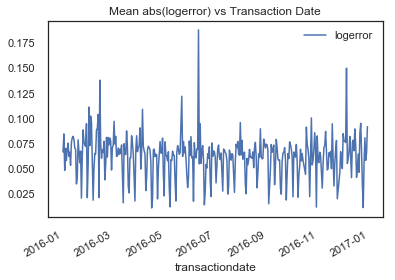

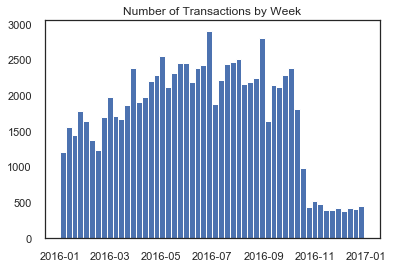

In [300]:
# plot logerrors over time
plt_df = df[['transactiondate','logerror']].copy()
plt_df['transactiondate'] = plt_df.transactiondate#.astype('datetime64[M]')
plt_df['logerror'] = np.abs(plt_df.logerror)
g = plt_df.groupby(['transactiondate']).mean()
g.plot()
plt.title("Mean abs(logerror) vs Transaction Date")
plt.show()
plt.hist(plt_df.transactiondate,bins=52)
plt.title("Number of Transactions by Week")
plt.show()

## <font color=red> This is the start of feature exploration, selection, and engineering... </font>

## Split dataset into train, dev, and test and filter to July 2016

In [301]:
keep = ['airconditioningtypeid','buildingqualitytypeid', 'heatingorsystemtypeid', 
                       'propertylandusetypeid','taxdelinquencyflag', 'county']
border_line = ['fireplaceflag','hashottuborspa']
drop = ['architecturalstyletypeid','buildingclasstypeid','latitude', 'longitude', 'censustractandblock',
        'typeconstructiontypeid', 'assessmentyear', 'regionidcity','regionidcounty','rawcensustractandblock',
                        'regionidneighborhood','regionidzip', 'transactiondate', 'latlng', 'county_city', 'city', 
       'propertycountylandusecode','propertyzoningdesc']

In [302]:
# split the dataset into train (60%), dev (20%), and test (20%)
# Set a random seed (623) to keep our dataset consistent between runs
# Only use data from July 2016

df = shuffle(df.copy(deep = True), random_state=623)
if drop is not None:
    df.drop(labels = drop, axis=1, inplace=True)

In [303]:

#df = df[(df['transactiondate'] >= '2016-07-01') & (df['transactiondate'] <= '2016-07-31')]

i_logerror = df.columns.get_loc("logerror")

train_data, train_labels = df.iloc[:int(len(df)*0.6), np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[:int(len(df)*0.6),i_logerror:(i_logerror+1)].values
df_train = df.iloc[:int(len(df)*0.6), :]
dev_data, dev_labels = df.iloc[int(len(df)*0.6):int(len(df)*0.8), np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[int(len(df)*0.6):int(len(df)*0.8),i_logerror:(i_logerror+1)].values
df_dev = df.iloc[int(len(df)*0.6):int(len(df)*0.8), :]
test_data, test_labels = df.iloc[int(len(df)*0.8):, np.r_[0:i_logerror, (i_logerror+1):len(df.columns)]], df.iloc[int(len(df)*0.8):,i_logerror:(i_logerror+1)].values
df_test = df.iloc[int(len(df)/2):, :]

### Histograms of features in our train dataset

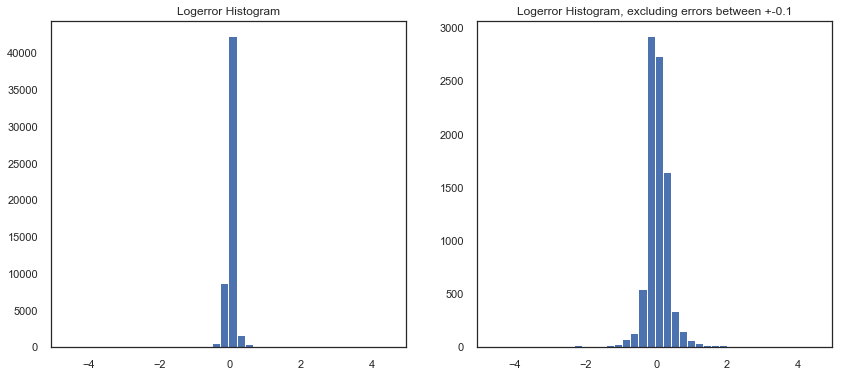

In [304]:
# plot histograms of Logerrors
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax.flatten()
ax[0].hist(df_train.logerror,bins=40)
ax[0].set_title("Logerror Histogram")
ax[1].hist(df_train.logerror[np.abs(df_train.logerror) >= 0.1],bins=40)
ax[1].set_title("Logerror Histogram, excluding errors between +-0.1")
plt.show()

## <font color=green> EH - Trying dimensionality reduction (PCA) on subsets of data </font>
We experiment with using PCA to group similar data (e.g. pool variables into a single dimension) then use the reduced projections moving forward

In [223]:
df_train.head()

,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,logerror,county
parcelid,,,,,,,,,,,,,,,,,,,,,
13888949,Blank,NaN,0.0,0.0,Low,NaN,NaN,1389.0,NaN,NaN,...,NaN,0,14900.0,132949.0,118049.0,3499.12,0,NaN,-0.0243,Orange County
14651704,Blank,NaN,3.0,3.0,Low,NaN,NaN,1536.0,1536.0,NaN,...,NaN,0,162226.0,383504.0,221278.0,3954.74,0,NaN,0.1258,Orange County
14237171,Blank,NaN,2.0,3.0,Low,NaN,NaN,1138.0,1138.0,NaN,...,1.0,0,32843.0,63892.0,31049.0,943.74,0,NaN,0.0459,Orange County
14196162,Yes,NaN,3.0,4.0,Low,NaN,NaN,2386.0,2386.0,NaN,...,2.0,0,187332.0,298594.0,111262.0,3808.80,0,NaN,0.0305,Orange County
11306735,Yes,NaN,3.0,4.0,High,NaN,NaN,3152.0,3152.0,NaN,...,NaN,0,207500.0,298000.0,90500.0,5025.83,0,NaN,0.0000,Los Angeles County


In [ ]:
# double check data types and shape
# df_train.dtypes
# df_train.shape

In [ ]:
# look at different groups of similar variables to understand if possible to combine
sqft = df_train[["finishedfloor1squarefeet", "calculatedfinishedsquarefeet",  "finishedsquarefeet12", "finishedsquarefeet15",
                 "finishedsquarefeet50", "finishedsquarefeet6"]]

garage = df_train[["garagecarcnt", "garagetotalsqft"]]

pool = df_train[["poolcnt", "pooltypeid7"]]

values = df_train[["structuretaxvaluedollarcnt", "taxvaluedollarcnt", "landtaxvaluedollarcnt", "taxamount"]]

region = df_train[["regionidcounty", "regionidcity", "regionidzip", "regionidneighborhood"]]


In [ ]:
# replace NaN values with the mean of each column
sqft = sqft.fillna(sqft.mean())
garage = garage.fillna(garage.mean())
pool = pool.fillna(pool.mean())
values = values.fillna(values.mean())
region = region.fillna(region.mean())

In [ ]:
# project grouped data into 1 dimension
sqft_projected = PCA(n_components = 1).fit_transform(sqft)
garage_projected = PCA(n_components = 1).fit_transform(garage)
values_projected = PCA(n_components = 1).fit_transform(values)
region_projected = PCA(n_components = 1).fit_transform(region)

# probably can't project pool data because the replacement value is all 1, so thre is no point of comparison
pool_projected = PCA(n_components = 1).fit_transform(pool)


## PCA with un-transformed data

First, create a subset that excludes the non-numeric variables. PCA only works well on continuous variables.

In [305]:
pca_train_data = train_data.select_dtypes(include=['float64','int64'])
pca_dev_data = dev_data.select_dtypes(include=['float64','int64'])
pca_train_data.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                    int64
lotsizesquarefeet               float64
poolcnt                         float64
pooltypeid7                     float64
propertylandusetypeid           float64
roomcnt                         float64
threequarterbathnbr             float64
unitcnt                         float64
yardbuildingsqft17              float64
yearbuilt                       float64
numberofstories                 float64
fireplaceflag                     int64


We'll also exclude categorical variables, since PCA explains variance and a category ID of 9 is likely just as different from an ID of 2 as it is an ID of 8.

In [317]:
for var in [pca_train_data,pca_dev_data]:
    var.drop(labels=['decktypeid','propertylandusetypeid','pooltypeid7'], axis=1, inplace=True)

C:\Users\amybr\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fill all NaNs accordingly. Some will make sense to set to another column, or set to the mean; others should just be zero.

In [309]:
for var in [pca_train_data, pca_dev_data]:
    # These should be set to zero if they aren't populated - they likely don't exist
    for col in ['calculatedfinishedsquarefeet','fireplacecnt','fullbathcnt',
               'garagecarcnt','garagetotalsqft','poolcnt','threequarterbathnbr',
                'yardbuildingsqft17','taxdelinquencyyear']:
        var[col].fillna(0, inplace=True)

    # Set unitcnt and number of stories to 1 if NaN
    var['unitcnt'].fillna(1,inplace=True)
    var['numberofstories'].fillna(1,inplace=True)

    # Set roomcnt to bedroomcnt+bathroomcnt
    var['roomcnt'].fillna(var['bedroomcnt']+var['bathroomcnt'], inplace=True)

    # Fill these with calculatedfinishedsquarefeet if they don't exist
    for col in ['finishedfloor1squarefeet','finishedsquarefeet12','finishedsquarefeet15',
               'finishedsquarefeet50','finishedsquarefeet6','lotsizesquarefeet']:
        var[col].fillna(var['calculatedfinishedsquarefeet'], inplace=True)

    # For the tax info, if the land value = total value, set structure NaN to 0 (it's just a lot)
    var[(var["taxvaluedollarcnt"] == 
                 var["landtaxvaluedollarcnt"])][["structuretaxvaluedollarcnt"]].fillna(0, inplace=True)

    # Now set every other NaN to the mean, since we don't have a better guess
    for col in ['yearbuilt', 'structuretaxvaluedollarcnt','taxvaluedollarcnt',
               'landtaxvaluedollarcnt','taxamount']:
        var[col].fillna(var[col].mean(), inplace=True)



Now normalize the columns

In [310]:
for col in pca_train_data.columns:
    for var in [pca_train_data, pca_dev_data]:
        var[col] = (var[col] - var[col].mean()) / var[col].std()

C:\Users\amybr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


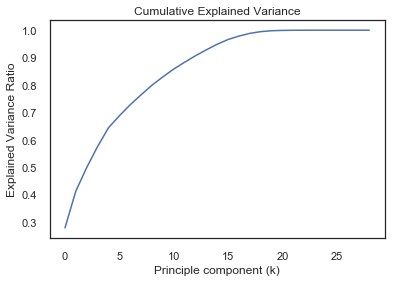

In [321]:
# Run PCA for all components
pca = PCA()
pca.fit(pca_train_data) 

# Create a cumulative line plot of the explained variance ratio for each of the principal components
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Cumulative Explained Variance')
plt.xlabel('Principle component (k)')
plt.ylabel('Explained Variance Ratio')
plt.show()

Looks like PCA with ~20 components retains nearly 100% of variance. This would reduce our number of features by about 1/3. 

In [322]:
pca = PCA(n_components = 20).fit(pca_train_data)
pca_20_train = pca.transform(pca_train_data)

### Partial Least Squares Regression (retains variance in both X and Y)

The problem with using PCA with this dataset is that PCA ignores how much variance in your Y variable is retained, and our objective is to maximize the variance in Y. PLSR is designed for datasets with lots of multicolinearity and instead attempts to maximize the retained variance in both the X and Y variables. 


We'll use the Variable Importance in Projection (VIP) score to identify which variable is contributing the least variance and systematically remove it. We'll calculate the percent variance in Y remaining after each iteration to get an elbow plot similar to that in PCA.


Good resource explaining PLSR: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.85.7735&rep=rep1&type=pdf

There's no built in package for calculating the Variable Importance in Projection (VIP) score, but we can calculate it using this function from https://github.com/scikit-learn/scikit-learn/issues/7050

In [323]:
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

I don't think I'm calculating explained variance properly, since it goes above 1. Need to do some work here...

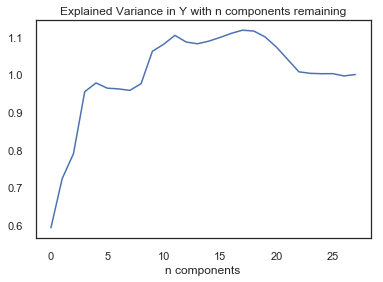

,explained_variance_y,col_w_lowest_VIP
27,1.0000,fireplaceflag
26,0.9963,unitcnt
25,1.0024,taxdelinquencyyear
24,1.0022,taxdelinquencyflag
23,1.0032,structuretaxvaluedollarcnt
22,1.0072,calculatedfinishedsquarefeet
21,1.0402,finishedsquarefeet12
20,1.0731,finishedsquarefeet15
19,1.1000,finishedsquarefeet6
18,1.1156,bedroomcnt


In [324]:
pls_train_data = pca_train_data.copy()

total_variance_in_y = explained_variance_score(train_labels, 
                                               PLSRegression().fit(pls_train_data, train_labels).predict(pls_train_data))

explained_variance_y = []
dropped_col = []

for i in range(1,len(pca_train_data.columns)):
    pls = PLSRegression().fit(pls_train_data, train_labels)
    vip_scores = vip(pls_train_data, train_labels,pls)
    
    # Get the variance in Y and save off   
    predict_y = pls.predict(pls_train_data)
    explained_variance_y.append(explained_variance_score(train_labels, predict_y)*1.0/total_variance_in_y)
    
    # Drop the column with the lowest VIP score
    j = np.argmin(vip_scores)
    dropped_col.append(pls_train_data.columns[j])
    pls_train_data.drop(labels=pls_train_data.columns[j], axis=1, inplace=True)

plt_df = pd.DataFrame({'explained_variance_y': explained_variance_y, 
                       'col_w_lowest_VIP': dropped_col}).sort_index(ascending=False).reset_index(drop=True)

plt.plot(plt_df.explained_variance_y)
plt.title("Explained Variance in Y with n components remaining")
plt.xlabel("n components")
plt.show()

plt_df.sort_index(ascending=False)

Ignore that for now. Let's just try running as a model and see how the MAE is:

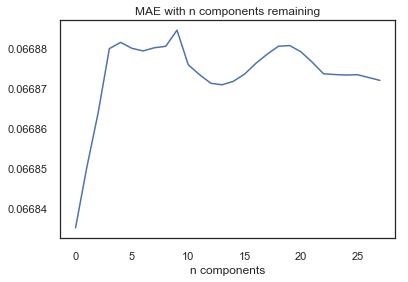

,MAE,col_w_lowest_VIP
27,0.0669,fireplaceflag
26,0.0669,unitcnt
25,0.0669,taxdelinquencyyear
24,0.0669,taxdelinquencyflag
23,0.0669,structuretaxvaluedollarcnt
22,0.0669,calculatedfinishedsquarefeet
21,0.0669,finishedsquarefeet12
20,0.0669,finishedsquarefeet15
19,0.0669,finishedsquarefeet6
18,0.0669,bedroomcnt


In [325]:
pls_train_data = pca_train_data.copy()
pls_dev_data = pca_dev_data.copy()

mae = []
dropped_col = []

for i in range(1,len(pca_train_data.columns)):
    pls = PLSRegression().fit(pls_train_data, train_labels)
    vip_scores = vip(pls_train_data, train_labels,pls)
    
    # Get the variance in Y and save off   
    predict_dev = pls.predict(pls_dev_data)
    mae.append(mean_absolute_error(dev_labels, predict_dev))
    
    # Drop the column with the lowest VIP score
    j = np.argmin(vip_scores)
    dropped_col.append(pls_train_data.columns[j])
    pls_train_data.drop(labels=pls_train_data.columns[j], axis=1, inplace=True)
    pls_dev_data.drop(labels=pls_dev_data.columns[j], axis=1, inplace=True)

plt_df = pd.DataFrame({'MAE': mae, 
                       'col_w_lowest_VIP': dropped_col}).sort_index(ascending=False).reset_index(drop=True)

plt.plot(plt_df.MAE)
plt.title("MAE with n components remaining")
plt.xlabel("n components")
plt.show()

plt_df.sort_index(ascending=False)

## Run Models

In [267]:
import importlib
importlib.reload(gauntlet)

<module 'gauntlet' from 'C:\\Users\\amybr\\Desktop\\W207_ML\\W207-Final-Project\\gauntlet.py'>

### Models on Ellie's PCA outputs

In [268]:
def concat_tables(*args):
    out_arr = []
    for arg in args:
        arg_np = np.array(arg)
        out_arr.append(arg_np)
        
    return np.concatenate(out_arr, axis=1)

full_data = concat_tables(sqft, garage, values, region)
projected_data = concat_tables(sqft_projected, garage_projected, values_projected, region_projected)
labels = df_train['logerror']

NameError: name 'region' is not defined

In [ ]:
gauntlet.compare_datasets(full_data, labels, projected_data, labels)

In [ ]:
from sklearn.neural_network import MLPRegressor
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, full_data, labels)
print(f'MLP Error: {err_:.3f}, Error std: {err_std_:.2f}')

It looks like the MLPRegressor is just bad. Maybe this could be improved via fiddling with the network architecture?

In [ ]:
# first let's try our rule of thumb
num_in_and_out = int((full_data.shape[1] + 1) * (2/3))
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, full_data, labels, hidden_layer_sizes=[num_in_and_out, 5], max_iter=1000)
print(f'MLP Improved Error: {err_:.3f}, Error std: {err_std_:.2f}')

That's a definite improvement. What if we tried it with the smaller data? Note that we are keeping the network architecture consistent.

In [ ]:
err_, err_std_ = gauntlet.cross_validate(MLPRegressor, projected_data, labels, hidden_layer_sizes=[num_in_and_out, 5], max_iter=1000)
print(f'MLP Improved Error: {err_:.3f}, Error std: {err_std_:.2f}')

Nope, still pretty bad. Now let's take a look at Gradient Boosting Trees, as this appears to have performed pretty well.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gauntlet.viz_model(GradientBoostingRegressor, full_data, labels)

It is very interesting that the training score decreases sharply as the amount of training data increases. This appears to indicate noise in the training data. The other thing that is immediately noticable in the prediction error plot is how grouped together the errors are around 0. Let's see what happens with the reduced dataset

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())
# gauntlet.viz_model(GradientBoostingRegressor, projected_data, labels)

### Models with 20-component PCA model vs full numerical dataset (31 features)

In [326]:
gauntlet.compare_datasets(pca_train_data, df_train['logerror'], pca_20_train, df_train['logerror'])

Dataset 1 Row Count: 54088, Feature Count: 29
Dataset 2 Row Count: 54088, Feature Count: 20
Cross validating and comparing...

Model: mlp, Data 1 error: 0.073, Data 2 error: 0.07, change: -0.176%
Model: knn, Data 1 error: 0.089, Data 2 error: 0.09, change: -0.298%
Model: tree, Data 1 error: 0.120, Data 2 error: 0.12, change: 0.532%
Model: gbt, Data 1 error: 0.069, Data 2 error: 0.07, change: -0.007%


Try GBT with the 20-component PCA

In [ ]:
gauntlet.viz_model(GradientBoostingRegressor, pca_20_train, df_train['logerror'])

In [ ]:
gauntlet.viz_model(GradientBoostingRegressor, pca_train_data, df_train['logerror'])

## t-SNE Clustering
We perform t-SNE clustering to identify if there is a visible grouping of higher `logerror`s. While t-SNE is not great for hard analysis, it is a good visualization utility and would allow us to identify if there is a clear grouping of variables with larger logerrors

In [ ]:
df_train.columns

In [ ]:
# remove categorical variables for now
# AB - removed censustractandblock, rawcensustractandblock, and binary features (hashottuborspa, fireplaceflag, taxdelinquincyflag)
tsne_train_columns = [
       'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'lotsizesquarefeet', 'poolcnt', 'roomcnt',
       'threequarterbathnbr', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 
       'taxdelinquencyyear', 'logerror',
       'transactiondate']
tsne_train_df = df_train[tsne_train_columns].copy()

tsne_train_df['transactiondate'] = tsne_train_df['transactiondate'].astype(np.int64)

drop_columns = []
for column in tsne_train_df.columns:
    if (~tsne_train_df[column].isna()).sum() > 5000:
        # Normalize all features here
        if column != 'logerror':
            tsne_train_df[column] = (tsne_train_df[column] - tsne_train_df[column].mean()) / tsne_train_df[column].std()
        continue
    
    drop_columns.append(column)
tsne_train_df.drop(drop_columns, axis='columns', inplace=True)


#tsne_train_df['transactiondate'] = (tsne_train_df['transactiondate'] - tsne_train_df['transactiondate'].mean()) / tsne_train_df['transactiondate'].std()
#tsne_train_df['assessmentyear'] = (tsne_train_df['assessmentyear'] - tsne_train_df['assessmentyear'].mean()) / tsne_train_df['assessmentyear'].std()
tsne_train_df.dropna(axis='rows', inplace=True)

tsna_train_np = tsne_train_df.loc[:,tsne_train_df.columns != 'logerror']
### WARNING!!! THIS TAKES A WHILE!!!
tsne_results = TSNE(n_components=2, verbose=1).fit_transform(tsna_train_np)

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha = .8, c = np.abs(tsne_train_df['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

As we saw in the earlier `logerror` distribution, a very large portion of the logerrors are extremely close to 0, making the colormapping difficult to understand. Let's observe the values both in and outside of these limits

In [ ]:
# filter out high logerrors
mask = np.abs(tsne_train_df['logerror']) < 0.1
tsne_train_df_sub = tsne_train_df[mask]
tsne_results_sub = tsne_results[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = np.abs(tsne_train_df_sub['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

In [ ]:
# filter out low logerrors
mask = np.abs(tsne_train_df['logerror']) > 0.1
tsne_train_df_sub = tsne_train_df[mask]
tsne_results_sub = tsne_results[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = np.abs(tsne_train_df_sub['logerror']), cmap = 'inferno')
cbar = plt.colorbar()

Unfortunately it doesn't look like there is a very large tendency for clusters to have similar logerror values, which means that this task will be pretty difficult. One very interesting thing to note is the linearity in the clusters that were created. Typically these clusters are both long and fat, but in this distribution it appears to be very tight and skinny. I'm not sure what this indicates.

In [ ]:
# AB  - crazy thought - what if we take the log(logerror) to better visualize?
#mask = np.abs(tsne_train_df['logerror']) < 0.1
tsne_train_df_sub = tsne_train_df #[mask]
tsne_results_sub = tsne_results #[mask]

plt.figure(figsize=(16,10))
plt.scatter(tsne_results_sub[:,0], tsne_results_sub[:,1], alpha = .8, c = -np.log(np.abs(tsne_train_df_sub['logerror'])), cmap = 'inferno')
cbar = plt.colorbar()